In [2]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190703.tar.gz -C ../raw_data

In [3]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190703"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)
    
print(df)

                                            sample N2O_peak  CO2_peak CH4_peak
0            Gas_NTC1-20cm_20190515-G_732019_1.txt    77517  31592447     3661
1           Gas_PTC2-120cm_20190524-G_732019_1.txt    85560  33751989     2728
2            Gas_PTT0-60cm_20190524-G_732019_1.txt    68291   2487324     5741
3                               N2OStd_0101ppm.txt    44629     46368        0
4                                 N2OStd_05ppm.txt    91759    121163        0
5                                 N2OStd_10ppm.txt  1134567     43193        0
6                                  N2OStd_1ppm.txt   161311    149158        0
7        QC-CO2Std_605ppm-CH4Std_5ppm-N2O_1ppm.txt   164204   1533810    13688
8  QC2-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm.txt    68747   1036595     5619


In [4]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

pd.set_option('display.max_rows', 90)
print(samples)

                                   sample N2O_peak  CO2_peak CH4_peak  \
0   Gas_NTC1-20cm_20190515-G_732019_1.txt    77517  31592447     3661   
1  Gas_PTC2-120cm_20190524-G_732019_1.txt    85560  33751989     2728   
2   Gas_PTT0-60cm_20190524-G_732019_1.txt    68291   2487324     5741   

  vial_pos method      date location depth  
0        1      G  20190515     NTC1    20  
1        1      G  20190524     PTC2   120  
2        1      G  20190524     PTT0    60  


In [5]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

               sample  N2O_peak  CO2_peak  CH4_peak     ppm
3  N2OStd_0101ppm.txt     44629     46368         0   0.101
4    N2OStd_05ppm.txt     91759    121163         0   0.500
5    N2OStd_10ppm.txt   1134567     43193         0  10.000
6     N2OStd_1ppm.txt    161311    149158         0   1.000
                                            sample N2O_peak CO2_peak CH4_peak
7        QC-CO2Std_605ppm-CH4Std_5ppm-N2O_1ppm.txt   164204  1533810    13688
8  QC2-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm.txt    68747  1036595     5619


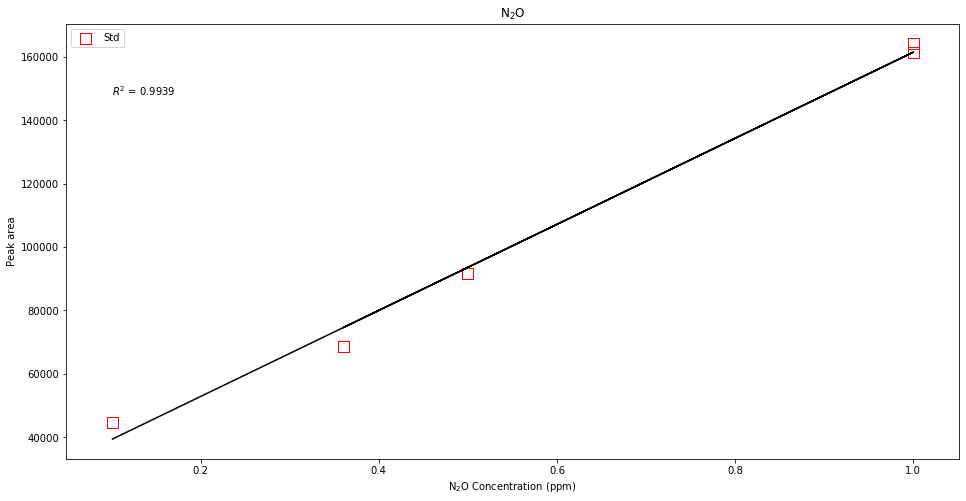

In [6]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Get indices of QCs
i = QC.index[QC['sample'] == 'QC2-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm.txt']
j = QC.index[QC['sample'] == 'QC-CO2Std_605ppm-CH4Std_5ppm-N2O_1ppm.txt']

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_10ppm')] # Drop 10 ppm
N2Ostd = N2Ostd.append({'ppm': 0.36, 'N2O_peak': QC.loc[i, 'N2O_peak'].values[0]}, ignore_index=True)
N2Ostd = N2Ostd.append({'ppm': 1.0, 'N2O_peak': QC.loc[j, 'N2O_peak'].values[0]}, ignore_index=True)

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')

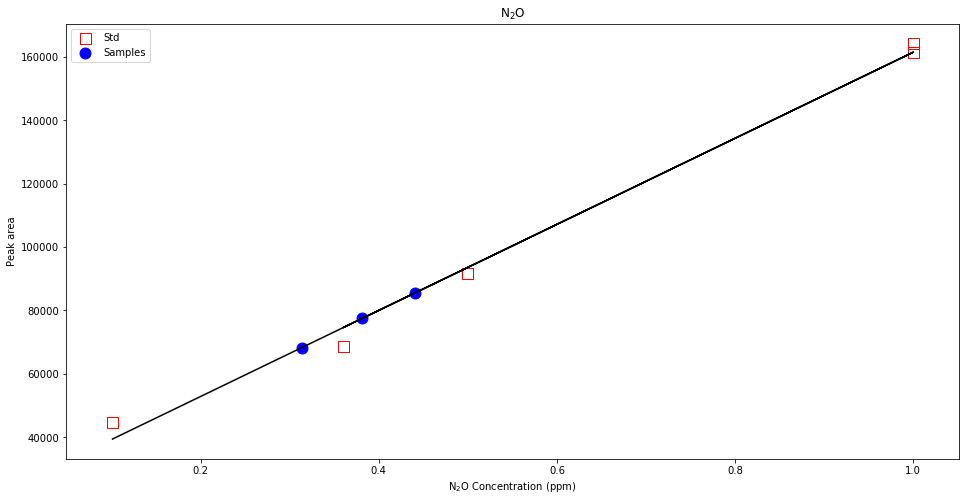

In [7]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")

In [8]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190703.txt", 
                                 write_to_datafile=True)
print(saveoutput)

  vial location depth       date method    dup  N2O_conc  N2O_bdl  CO2_conc  \
0    1     NTC1    20 2019-05-15      G  False  0.381478    False       NaN   
1    1     PTC2   120 2019-05-24      G  False  0.440711    False       NaN   
2    1     PTT0    60 2019-05-24      G  False  0.313533    False       NaN   

   CO2_bdl  CH4_conc  CH4_bdl  
0      NaN       NaN      NaN  
1      NaN       NaN      NaN  
2      NaN       NaN      NaN  
